# Advanced Lane Finding Project
The goals / steps of this project are the following:
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Apply a perspective transform to rectify binary image ("birds-eye view").
4. Use color transforms and gradients to create a thresholded binary image.
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
9. Create a pipeline to executes all the steps above 
10. Run the pipeline to detect lane lines in a given video and output a new video showing the results.
11. Plot all the steps showing the approach of this project

## Import all packages

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline
import matplotlib.image as mpimg



## 1. Camera Calibration

In [2]:
########################################################################################################
# 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
#########################################################################################################

def CamCali(disp=0, imageNo=12):
    i = 0
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')


    # Step through the list and search for chessboard corners
    for fname in images:
        i = i +1
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            
            # Calibrate Camera
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
            
            # undistort images
            img_undis = cv2.undistort(img, mtx, dist, None, mtx)
            
            if disp == 1 and i == imageNo:
                
                # Display the corners on original and undistorted images 
                f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
                f.tight_layout()
                ax1.imshow(img)
                ax1.set_title('Original Image', fontsize=17)
                ax2.imshow(img_undis)
                ax2.set_title('Undistorted Image', fontsize=17)
                #plt.subplots_adjust(left=0., right=1, top=0., bottom=0.)
                plt.savefig('output_images/chess_cornerDraw_undis_{}.jpg'.format(i))

            
            
    return ret, mtx, dist, rvecs, tvecs, img, img_undis


## 2. Distortion Correction

In [3]:
#################################################
# 2. Apply a distortion correction to raw images.
##################################################

def undistortion (img, mtx, dist):
    img_undis = cv2.undistort(img, mtx, dist, None, mtx)
    return img_undis

## 3. Persective Transform

In [4]:
#############################################################
# 3. Apply a perspective transform image ("birds-eye view").
#############################################################

def warp (img):
    
    # define destination coordinates of lane lines
    dst_lb = [320,710]  # left bottom coordinate
    dst_rb = [980, 710] # right bottom coordinate
    dst_lt = [320, 1]   # left top coordinate
    dst_rt = [980, 1]   # right top coordinate

    # define source coordinates of lane lines
    src_lb = [220,710]  # left bottom coordinate
    src_rb = [1100,710] # right bottom coordinate
    src_lt = [570, 470] # left top coordinate
    src_rt = [718, 470] # right top coordinate
    
    img_size = (img.shape[1], img.shape[0])
    
    # 4 source coordinates
    src = np.float32([src_lb, src_rb, src_rt, src_lt])
    
    # 4 destination coordinates
    dst = np.float32([dst_lb, dst_rb, dst_rt, dst_lt])
    
    #Compute the perspective transform, M, given source and destination points
    M = cv2.getPerspectiveTransform(src, dst)
    
       
    #Warp an image using the perspective transform, M
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
      
    return warped


def unwarp (img):
    
    # define destination coordinates of lane lines
    dst_lb = [320,710]  # left bottom coordinate
    dst_rb = [980, 710] # right bottom coordinate
    dst_lt = [320, 1]   # left top coordinate
    dst_rt = [980, 1]   # right top coordinate

    # define source coordinates of lane lines
    src_lb = [220,710]  # left bottom coordinate
    src_rb = [1100,710] # right bottom coordinate
    src_lt = [570, 470] # left top coordinate
    src_rt = [718, 470] # right top coordinate
    
    img_size = (img.shape[1], img.shape[0])
    
    # 4 source coordinates
    src = np.float32([src_lb, src_rb, src_rt, src_lt])
    
    # 4 destination coordinates
    dst = np.float32([dst_lb, dst_rb, dst_rt, dst_lt])
    
    #Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
        
    #Unwarp an image using the perspective transform, Minv
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return unwarped

## 4. Thresholding

### 4.1 Color Thresholding

In [5]:
###############################################################
# 4. Use color transforms to create a thresholded binary image.
###############################################################


### Color Thesholding Definitions

# create threshold binary image for color functions
def binary_col(img, thresh=(180, 255)):
    binary =  np.zeros_like(img)
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary

# Grayscale threshold
def gray_thresh (img, binary = 1, thresh = (180, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if binary == 1:
        gray = binary_col(gray, thresh=(180, 255))    
    return gray


# RGB threshold
def RGB_thresh (img, binary = 1, thresh = (200, 255)):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    if binary == 1:
        R = binary_col(R, thresh = thresh)
        G = binary_col(G, thresh = thresh)
        B = binary_col(B, thresh = thresh)    
    return R, G, B


# HLS threshold
def HLS_thresh (img, binary = 1, thresh_H = (15, 100), thresh_L = (15, 100), thresh_S = (90, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    if binary == 1:
        H = binary_col(H, thresh = thresh_H)
        L = binary_col(L, thresh = thresh_L)
        S = binary_col(S, thresh = thresh_S)    
    return H, L, S

# Function to combine and tune color thresholding
def Color_Thresh (img):
    
    gray = gray_thresh (img, binary = 0, thresh = (180, 255))
    gray_binary = gray_thresh (img, binary = 1, thresh = (180, 255))

    R, G, B = RGB_thresh (img, binary = 0, thresh = (190, 255))
    R_b, G_b, B_b = RGB_thresh (img, binary = 1, thresh = (190, 255))

    H, L, S = HLS_thresh (img, binary = 0, thresh_H = (15, 100), thresh_L = (150, 255), thresh_S = (100, 255))
    H_b, L_b, S_b = HLS_thresh (img, binary = 1, thresh_H = (15, 100), thresh_L = (150, 255), thresh_S = (100, 255))
    
    # combination stack of S and H channel
    comb_color = np.dstack(( np.zeros_like(S), S, H, B))
    comb_color_binary = np.zeros_like(S_b)
    comb_color_binary[(S_b == 1) & (H_b == 1) | (B_b == 1)] = 1
    
    return gray, gray_binary, R, R_b, G, G_b, B, B_b, H, H_b, L, L_b, S, S_b, comb_color, comb_color_binary



### 4.2 Gradient Thresholding

In [6]:
#########################################################
# 4. Use gradient to create a thresholded binary image.
#########################################################


### Gradient Thesholding Definitions

# create threshold binary image for gradient functions
def binary_grad(img, thresh=(0, 255)):
    binary =  np.zeros_like(img)
    binary[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary


# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sobel_binary = binary_grad(scaled_sobel, thresh=thresh)       
    return sobel_binary
    

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    mag_binary = binary_grad(gradmag, thresh=thresh)    
    return mag_binary


# Define a function to threshold an image for a given range and Sobel kernel
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = binary_grad(absgraddir, thresh=thresh)
    return dir_binary
    
# Function to combine and tune gradient thresholding
def Gradient_Thresh (img):
    
    sobelx = abs_sobel_thresh(img, orient='x', thresh=(10, 255))
    sobely = abs_sobel_thresh(img, orient='y', thresh=(12, 255))
    mag_binary = mag_thresh(img, sobel_kernel=15, thresh=(30, 255))
    dir_binary = dir_thresh(img, sobel_kernel=9, thresh=(0.1, 1.2))
    
    return sobelx, sobely, mag_binary, dir_binary

### 4.3 Color and Gradient Thresholding combined 

In [7]:
# Function to combine color and gradient thresholding
    
def Color_Gradient_Thresh(comb_color_binary, mag_binary, dir_binary):
    
    binary = np.zeros_like(mag_binary)
    binary[(mag_binary == 1) | (comb_color_binary == 1) ] = 1
    
    return binary

## 5. Finding Lane Lines

In [8]:
##########################################################
# 5. Detect lane pixels and fit to find the lane boundary.
##########################################################


def Lane_SlideWindows (img):
    stop = 0        # value showing if lane have been detected at all
    img_stop = img  # if no lane detected, give out this image without lane detection marks
    
    # 1. Histogramm
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    
    # 2. sliding window
    out_img = 255*np.dstack((img, img, img)).astype('uint8') 

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])


    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    #create a cooy of image for cv2
    out_img_copy = out_img.copy()
    

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        img_rect = cv2.rectangle(out_img_copy,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4)
        img_rect = cv2.rectangle(out_img_copy,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4) 


        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
              
        # Append these indices to the lists    
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)    
    
    # if no lane detected, give out image without lane detection marks   
    if np.all(left_lane_inds == 0) or np.all(right_lane_inds == 0):
        print ('Stop ON')
        stop = 1
        leftx=None
        lefty=None
        rightx=None
        righty=None
        left_fit=None
        right_fit=None
        ploty=None
        left_fitx=None
        right_fitx=None
        out_img= img_stop             
        
    else:   
        stop = 0
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        img_rect[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        img_rect[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        out_img = img_rect


    return leftx, lefty, rightx, righty, left_fit, right_fit, ploty, left_fitx, right_fitx, out_img, stop, histogram


def Lane_SearchWindow (img, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video 
    # It's now much easier to find line pixels!
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Visualization

    # Create an image to draw on and an image to show the selection window
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = 255*np.dstack((img, img, img)).astype('uint8') 
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    return leftx, lefty, rightx, righty, left_fit, right_fit, ploty, left_fitx, right_fitx, out_img, window_img, left_line_pts, right_line_pts



## 6. Curvature and Center Offset Position

In [9]:
#####################################################################################
# 6. Determine the curvature of the lane and vehicle position with respect to center.
#####################################################################################

def curv_pos (img, left_fit, right_fit, ploty, left_fitx, right_fitx):

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48


    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    curverad = (left_curverad + right_curverad)/2

    # center lane calculation
    camera_position = img.shape[1]/2
    lane_center = (right_fitx[719] + left_fitx[719])/2
    center_offset_pixels = camera_position - lane_center
    center_offset_meter = xm_per_pix * center_offset_pixels

    return left_curverad, right_curverad, curverad, center_offset_meter

## 7. Warp back 

In [10]:
#####################################################################
# 7. Warp the detected lane boundaries back onto the original image.
#####################################################################

def WarpOnOriginal(img_undis, left_fitx, right_fitx, ploty):
    overlay =  np.zeros_like(img_undis).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane with low confidence region in red
    LaneArea = cv2.fillPoly(overlay, np.int_([pts]), (0, 255, 0))
    newwarp = unwarp (LaneArea)
    
    # Combine the result with the original image
    result = cv2.addWeighted(img_undis, 1, newwarp, 0.4, 0)
    
    return result, LaneArea, newwarp

## 8. Visual Output 

In [11]:
##################################################################################################################
# 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
##################################################################################################################

def vis_out (result_img, curverad, center_offset_meter):
    img_text = result_img.copy()
    cv2.putText(img_text, "Radius of Curvature = {}".format(curverad), (100, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)
    cv2.putText(img_text, "Lane Position Offset = {}".format(center_offset_meter), (100, 120), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)
    
    return img_text


## 9. Pipeline

In [12]:
########################################################
# 9.Create a pipeline t0 executes all the steps above 
#######################################################

## Pipeline for plots
def pipeline_test (img, mtx, dist):
    #1. Undistortion
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
    img_undis = undistortion (img, mtx, dist)  
    warped_img = warp (img_undis)
    gray, gray_binary, R, R_b, G, G_b, B, B_b, H, H_b, L, L_b, S, S_b, comb_color, comb_color_binary = Color_Thresh(warped_img)
    sobelx, sobely, mag_binary, dir_binary = Gradient_Thresh(comb_color_binary) 
    warped_binary = Color_Gradient_Thresh(comb_color_binary, mag_binary, dir_binary)
    
    leftxSW, leftySW, rightxSW, rightySW, first_left_fit, first_right_fit, plotySW, left_fitxSW, right_fitxSW, out_imgSW,\
    stop, histogram = Lane_SlideWindows (warped_binary)   
    
    leftx, lefty, rightx, righty, left_fit, right_fit, ploty, left_fitx, right_fitx, out_img_search, window_img, left_line_pts,\
    right_line_pts = Lane_SearchWindow (warped_binary, first_left_fit, first_right_fit)
    
    left_curverad, right_curverad, curverad, center_offset_meter = curv_pos (warped_binary, left_fit, right_fit, ploty,\
                                                                             left_fitx, right_fitx)
    
    result_img, LaneArea, newwarp = WarpOnOriginal(img_undis, left_fitx, right_fitx, ploty)
    
    result_img_text = vis_out (result_img, curverad, center_offset_meter)
    
    return img, img_undis, warped_img, gray, gray_binary, R, R_b, G, G_b, B, B_b, H, H_b, L, L_b, S, S_b, comb_color, comb_color_binary,\
sobelx, sobely, mag_binary, dir_binary, warped_binary, plotySW, left_fitxSW, right_fitxSW, out_imgSW, histogram, ploty, left_fitx,\
right_fitx, out_img_search, window_img, left_line_pts, right_line_pts, result_img, LaneArea, newwarp, result_img_text



## final Pipeline for the video

def pipeline (img, mtx, dist):
   
    img_undis = undistortion (img, mtx, dist)
    warped_img = warp (img_undis)
    gray, gray_binary, R, R_b, G, G_b, B, B_b, H, H_b, L, L_b, S, S_b, comb_color, comb_color_binary = Color_Thresh(warped_img)
    sobelx, sobely, mag_binary, dir_binary = Gradient_Thresh(comb_color_binary) 
    warped_binary = Color_Gradient_Thresh(comb_color_binary, mag_binary, dir_binary)
    
    leftx, lefty, rightx, righty, first_left_fit, first_right_fit, ploty, left_fitx, right_fitx, out_img_slide, stop,\
    histogram = Lane_SlideWindows (warped_binary)
    
    if stop == 0:
        leftx, lefty, rightx, righty, left_fit, right_fit, ploty, left_fitx, right_fitx, out_img, window_img, left_line_pts,\
        right_line_pts = Lane_SearchWindow (warped_binary, first_left_fit, first_right_fit)
        
        left_curverad, right_curverad, curverad, center_offset_meter = curv_pos (warped_binary, left_fit, right_fit, ploty,\
                                                                                 left_fitx, right_fitx)
        
        result_img, LaneArea, newwarp = WarpOnOriginal(img_undis, left_fitx, right_fitx, ploty)
        result_img_text = vis_out (result_img, curverad, center_offset_meter)
       
    if stop == 1:        
         result_img_text = img_undis
        
            
    return result_img_text

## 10. Creating the Video

In [13]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
#imageio.plugins.ffmpeg.download import ffmpeg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
########################################################################################################
# 10. Run the pipeline to detect lane lines in a given video and output a new video showing the results. 
########################################################################################################

ret, mtx, dist, rvecs, tvecs, img, img_undis = CamCali(disp=0, imageNo=12)

result_video = 'result_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
result_clip = clip1.fl_image(lambda img: pipeline(img, mtx, dist))
%time result_clip.write_videofile(result_video, audio=False)




[MoviePy] >>>> Building video result_video.mp4
[MoviePy] Writing video result_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [14:41<00:00,  1.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_video.mp4 

Wall time: 14min 45s


## 11. Playground for ploting and saving the test images

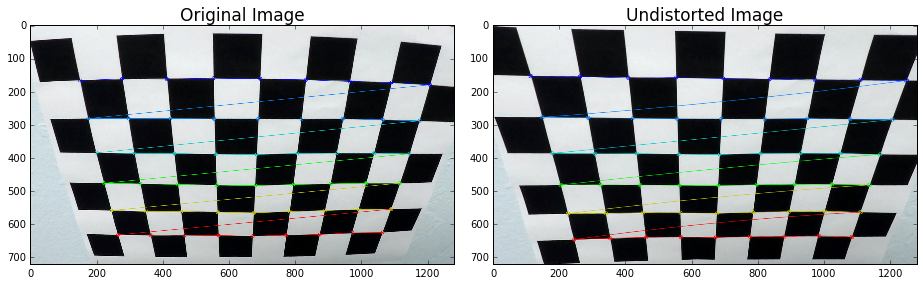

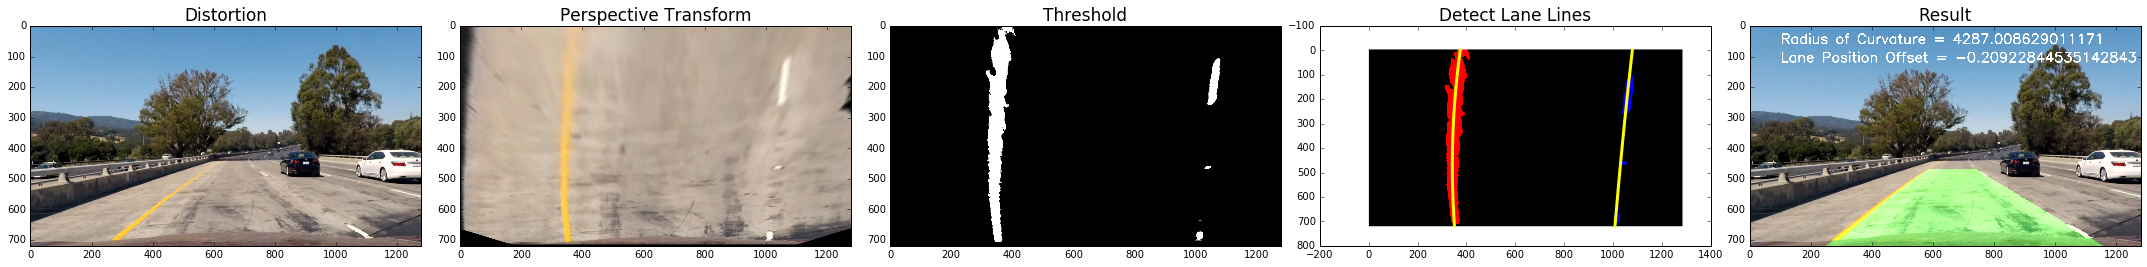

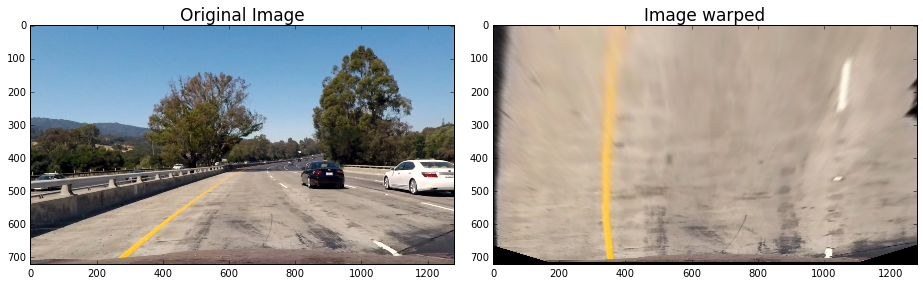

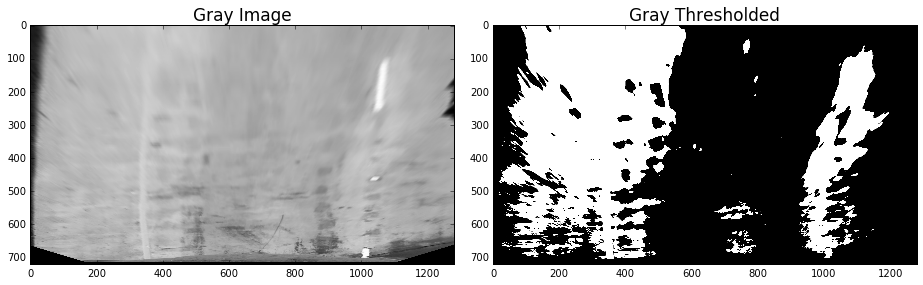

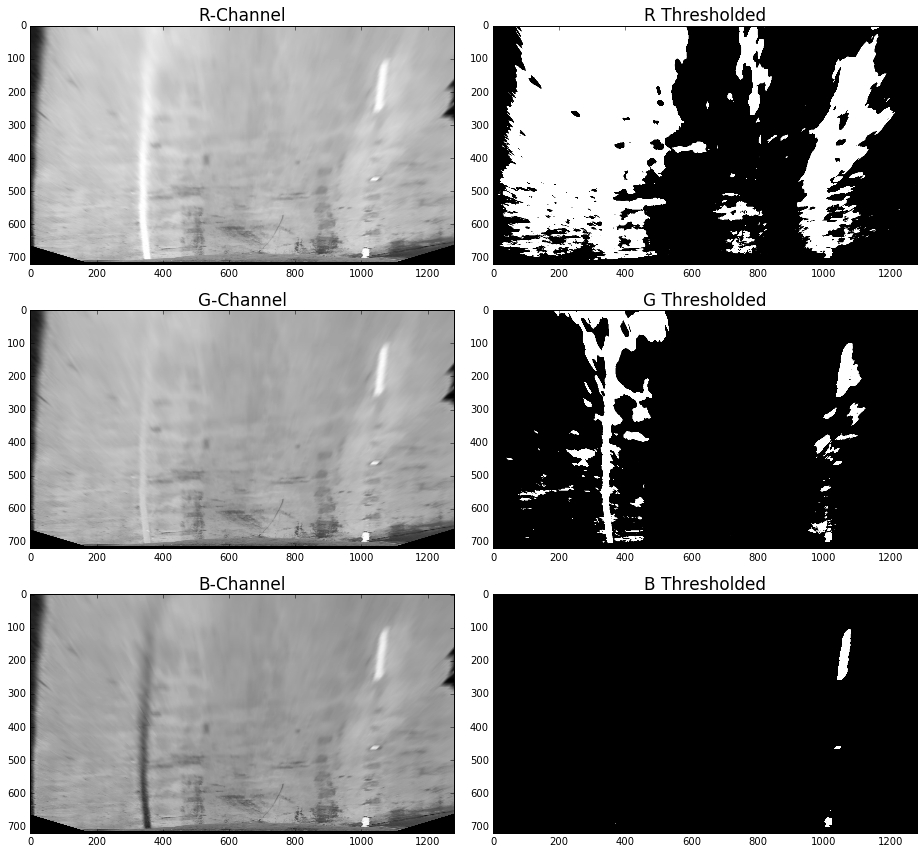

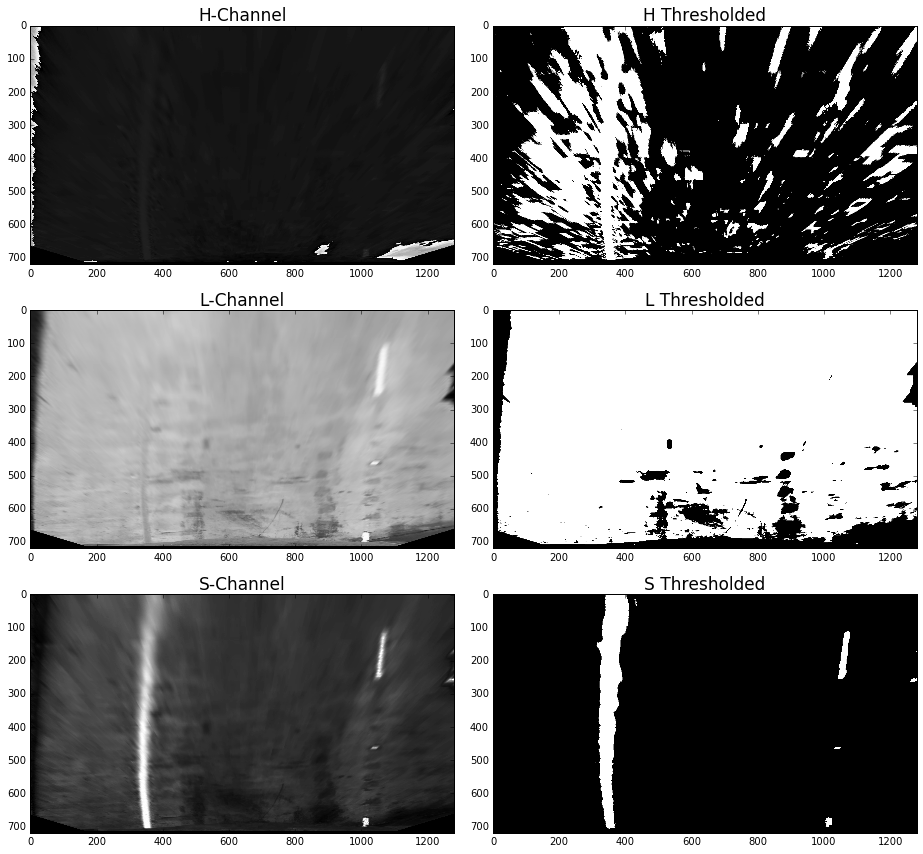

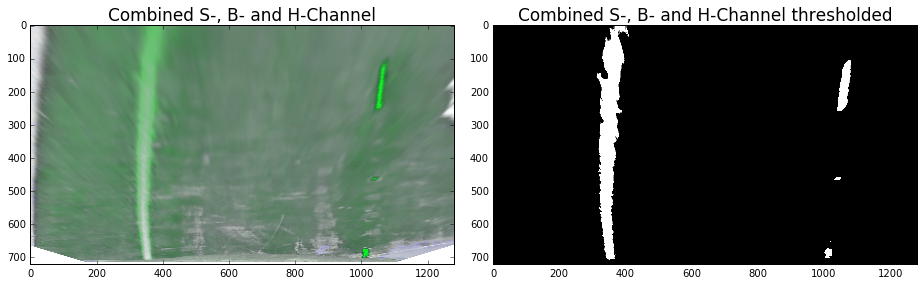

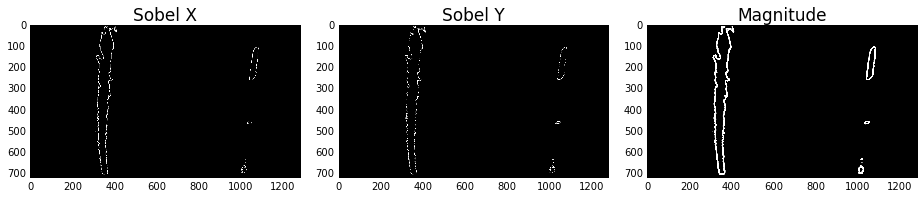

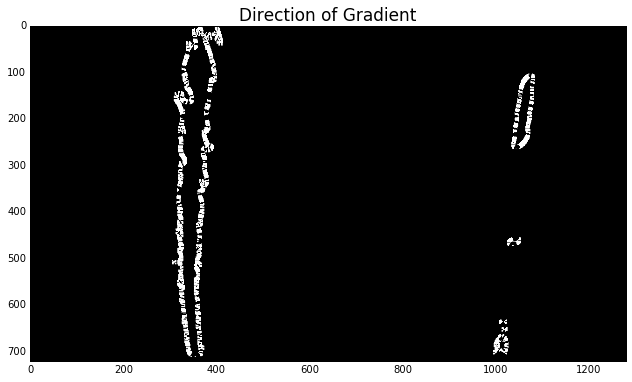

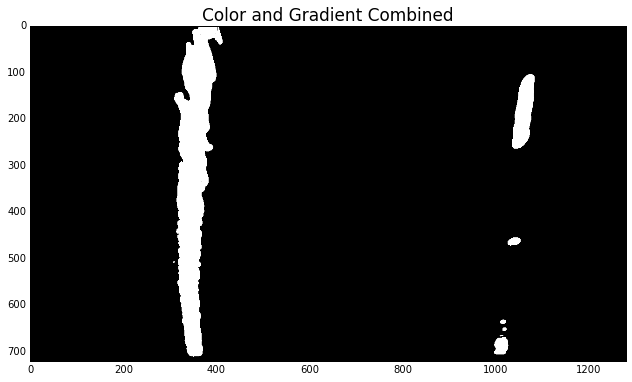

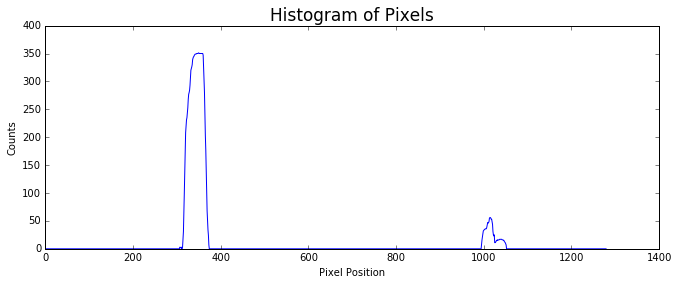

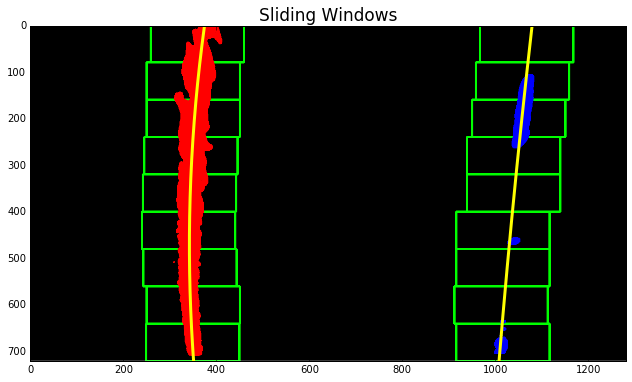

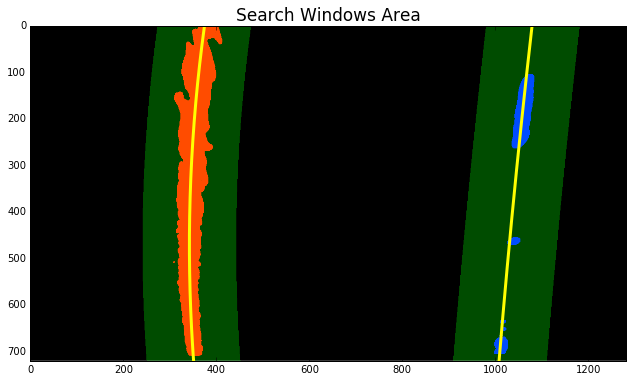

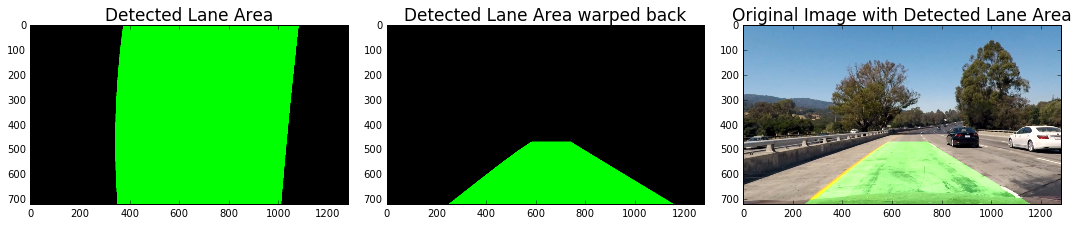

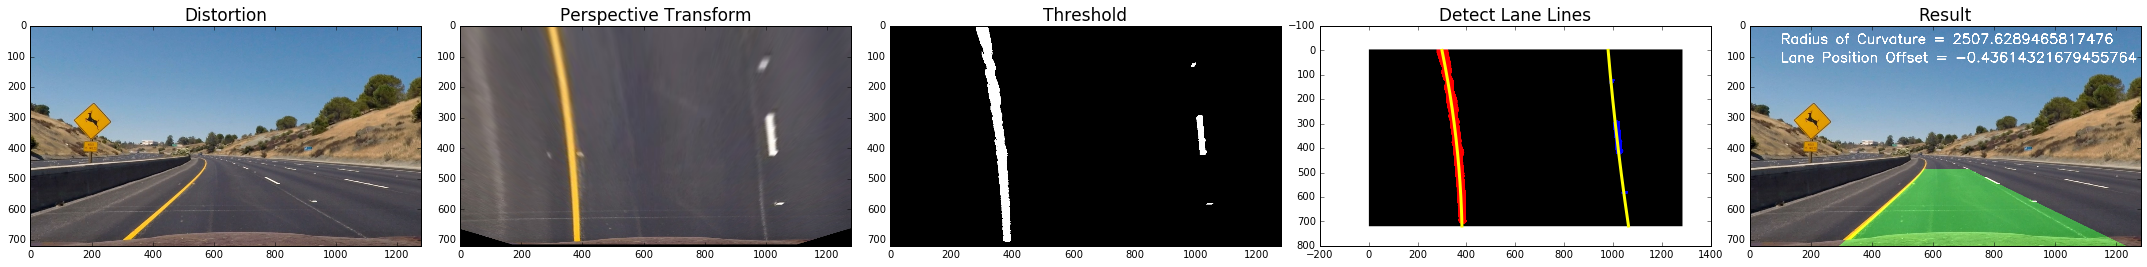

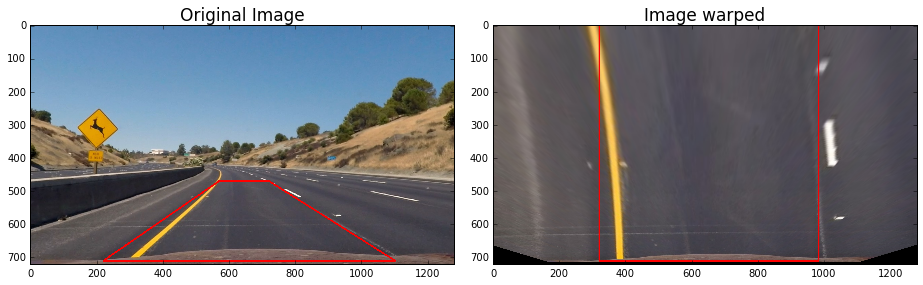

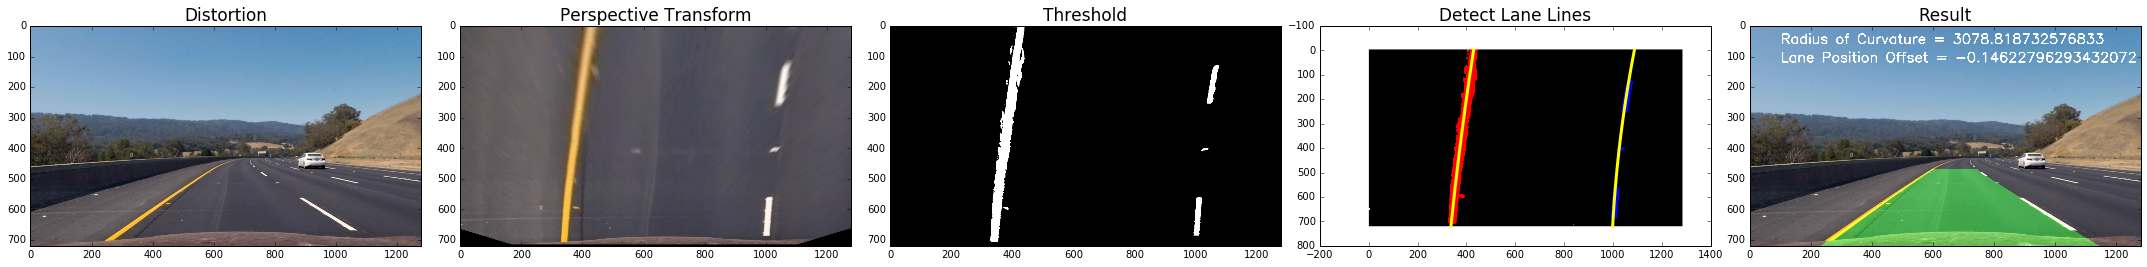

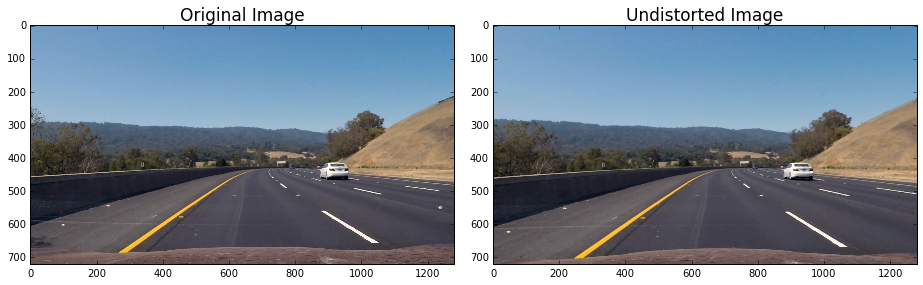

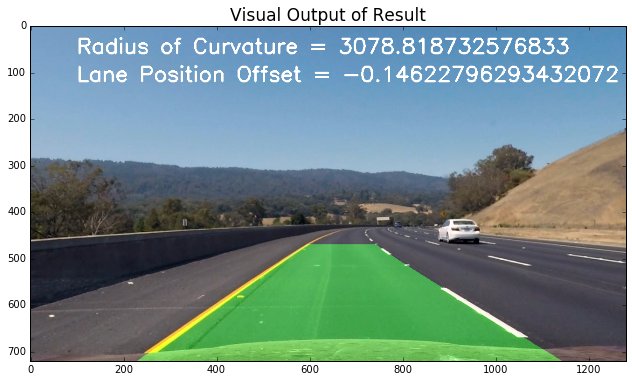

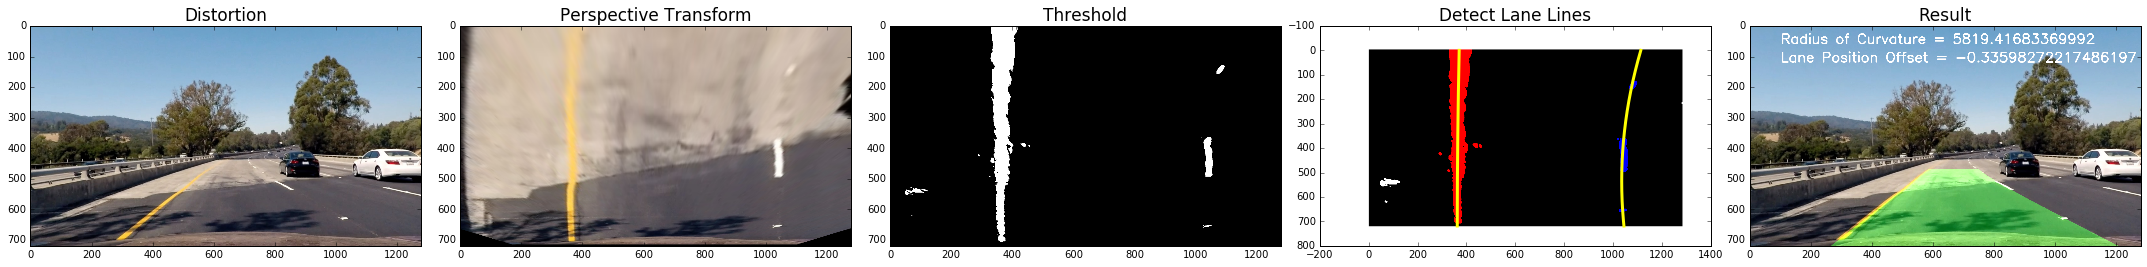

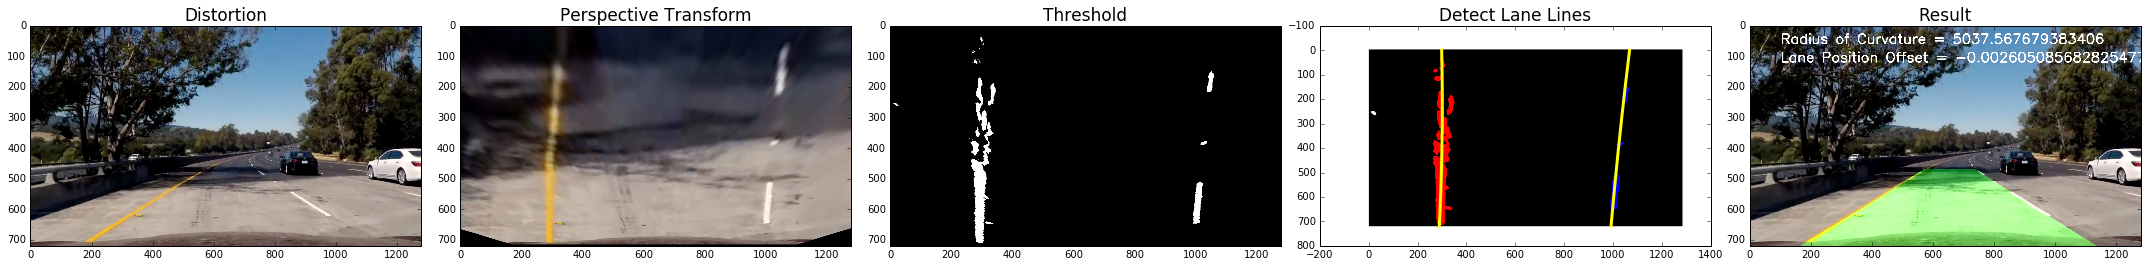

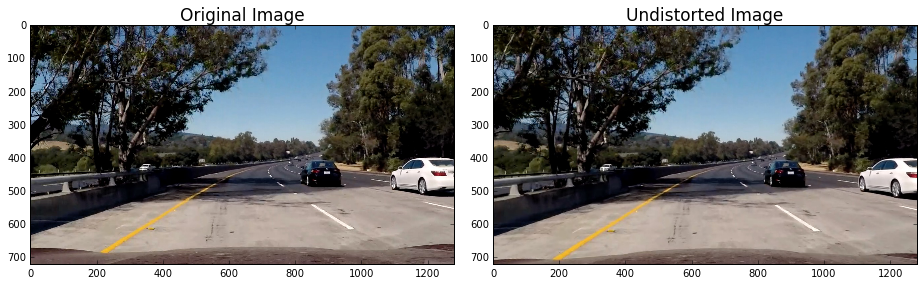

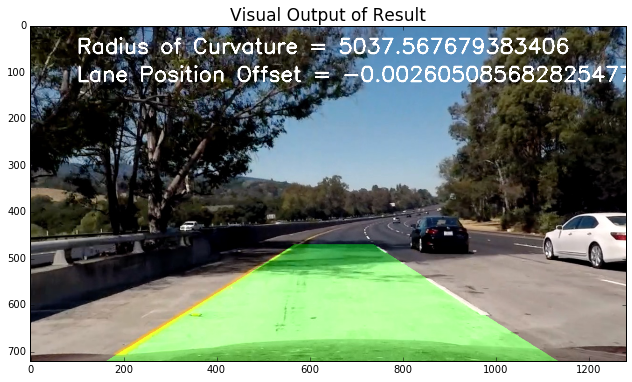

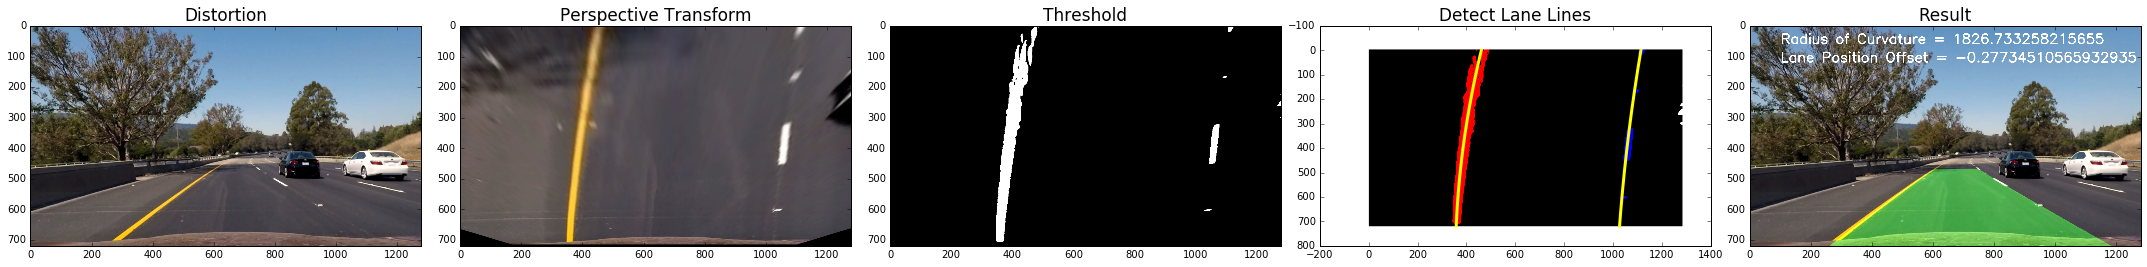

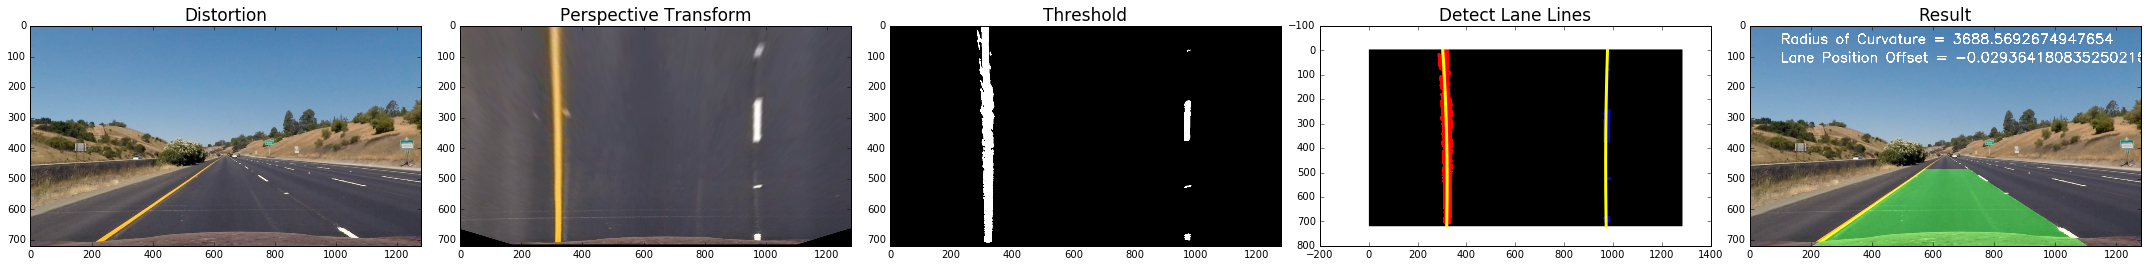

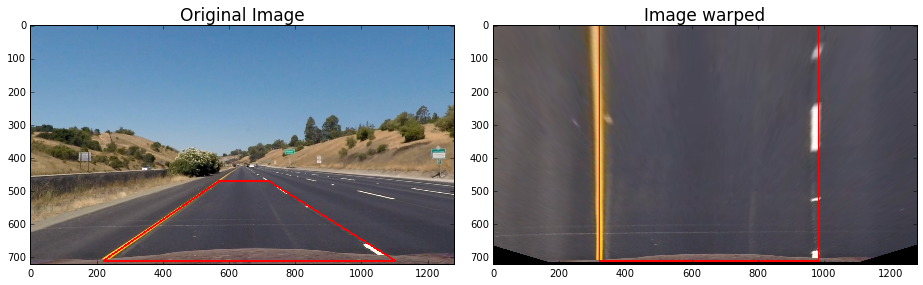

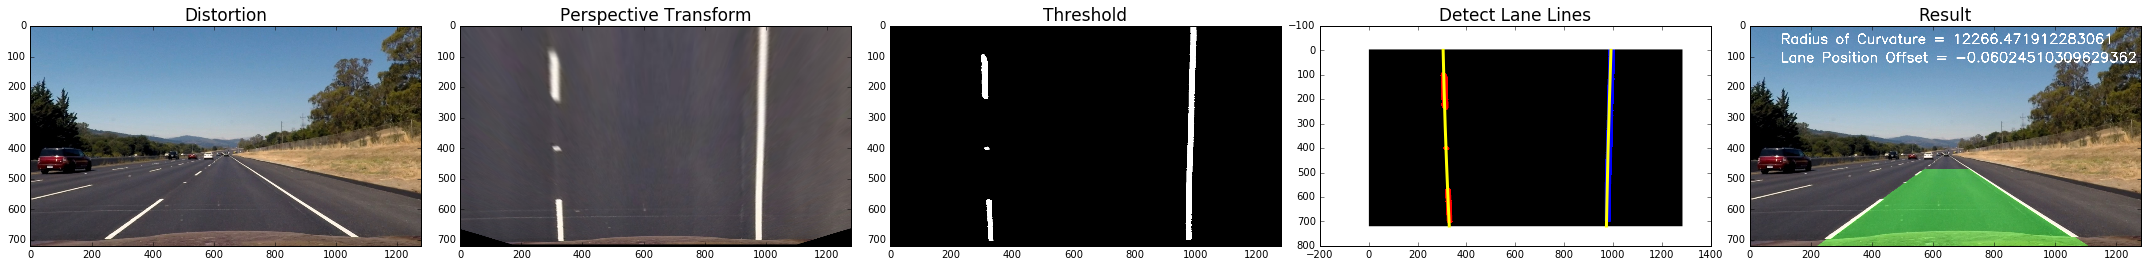

In [15]:
##############################################################
# 11. Plot all the steps showing the approach of this project
##############################################################


# get distortion cefficients with camera calibration
ret, mtx, dist, rvecs, tvecs, img, img_undis = CamCali(disp=1, imageNo=12)

# Make a list of images
images = glob.glob('test_images/test*.jpg')

i = 0
for fname in images:
    i = i+1
    img = cv2.imread(fname)   
    img, img_undis, warped_img, gray, gray_binary, R, R_b, G, G_b, B, B_b, H, H_b, L, L_b, S, S_b, comb_color, comb_color_binary,\
sobelx, sobely, mag_binary, dir_binary, warped_binary, plotySW, left_fitxSW, right_fitxSW, out_imgSW, histogram, ploty,\
left_fitx, right_fitx, out_img_search, window_img, left_line_pts, right_line_pts, result_img, LaneArea, newwarp,\
result_img_text = pipeline_test(img, mtx, dist)

    # Display Summary of all steps and images
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30, 4))
    f.tight_layout()
    ax1.imshow(img_undis)
    ax1.set_title('Distortion', fontsize=17)
    ax2.imshow(warped_img)
    ax2.set_title('Perspective Transform', fontsize=17)
    ax3.imshow(comb_color_binary, cmap='gray')
    ax3.set_title('Threshold', fontsize=17)
    ax4.imshow(out_img_search)
    ax4.plot(left_fitx, ploty, color='yellow', linewidth=3)
    ax4.plot(right_fitx, ploty, color='yellow', linewidth=3)
    ax4.set_title('Detect Lane Lines', fontsize=17)
    ax5.imshow(result_img_text)
    ax5.set_title('Result', fontsize=17)
    plt.savefig('output_images/Summary_{}.jpg'.format(i))
        
        
        
    if i == 3 or i == 5:
        # Plot undistortion 
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=17)
        ax2.imshow(img_undis)
        ax2.set_title('Undistorted Image', fontsize=17)
        plt.savefig('output_images/Undistortion_{}.jpg'.format(i))
        
        
        # Display the result as visual output
        plt.figure(figsize=(15, 6))
        plt.imshow(result_img_text)
        plt.title('Visual Output of Result', fontsize=17)
        plt.savefig('output_images/ResultImageText_{}.jpg'.format(i))
        plt.show()
        
        
    if i == 2 or i == 7:
        #Plot warp
        img_undis_copy = img_undis.copy()
        warped_img_copy = warped_img.copy()
        dst_lb = [320,710] 
        dst_rb = [980, 710]
        dst_lt = [320, 1]
        dst_rt = [980, 1]

        src_lb = [220,710]
        src_rb = [1100,710]
        src_lt = [570, 470]
        src_rt = [718, 470]
    
        pts_src = np.array([src_lb, src_rb, src_rt, src_lt])
        pts_dst = np.array([dst_lb, dst_rb, dst_rt, dst_lt])
        lines_src = cv2.polylines(img_undis_copy,[pts_src],True,(255,0,0), 3) 
        lines_dst = cv2.polylines(warped_img_copy,[pts_dst],True,(255,0,0), 3) 

        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
        f.tight_layout()
        ax1.imshow(lines_src)
        ax1.set_title('Original Image', fontsize=17)
        ax2.imshow(lines_dst)
        ax2.set_title('Image warped', fontsize=17)
        plt.savefig('output_images/warp_{}.jpg'.format(i))
        plt.show()
        
        
    if i == 1:
        #Display original and warped image to introduce before thresholding 
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
        f.tight_layout()
        ax1.imshow(img_undis)
        ax1.set_title('Original Image', fontsize=17)
        ax2.imshow(warped_img)
        ax2.set_title('Image warped', fontsize=17)
        plt.savefig('output_images/OriginalForThresh.jpg')
        plt.show()
        
        # Display gray and thesholded image 
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
        f.tight_layout()
        ax1.imshow(gray, cmap='gray')
        ax1.set_title('Gray Image', fontsize=17)
        ax2.imshow(gray_binary, cmap='gray')
        ax2.set_title('Gray Thresholded', fontsize=17)
        plt.savefig('output_images/gray_and_thresh.jpg')
        plt.show()
        
        # Display RGB and thesholded image 
        f, ((ax1, ax2), (bx1, bx2), (cx1, cx2)) = plt.subplots(3, 2, figsize=(13, 12))
        f.tight_layout()
        ax1.imshow(R, cmap='gray')
        ax1.set_title('R-Channel', fontsize=17)
        ax2.imshow(R_b, cmap='gray')
        ax2.set_title('R Thresholded', fontsize=17)
        bx1.imshow(G, cmap='gray')
        bx1.set_title('G-Channel', fontsize=17)
        bx2.imshow(G_b, cmap='gray')
        bx2.set_title('G Thresholded', fontsize=17)
        cx1.imshow(B, cmap='gray')
        cx1.set_title('B-Channel', fontsize=17)
        cx2.imshow(B_b, cmap='gray')
        cx2.set_title('B Thresholded', fontsize=17)
        plt.savefig('output_images/RGB_and_thresh.jpg')
        plt.show()
        
        # Display HLS and thesholded image 
        f, ((ax1, ax2), (bx1, bx2), (cx1, cx2)) = plt.subplots(3, 2, figsize=(13, 12))
        f.tight_layout()
        ax1.imshow(H, cmap='gray')
        ax1.set_title('H-Channel', fontsize=17)
        ax2.imshow(H_b, cmap='gray')
        ax2.set_title('H Thresholded', fontsize=17)
        bx1.imshow(L, cmap='gray')
        bx1.set_title('L-Channel', fontsize=17)
        bx2.imshow(L_b, cmap='gray')
        bx2.set_title('L Thresholded', fontsize=17)
        cx1.imshow(S, cmap='gray')
        cx1.set_title('S-Channel', fontsize=17)
        cx2.imshow(S_b, cmap='gray')
        cx2.set_title('S Thresholded', fontsize=17)
        plt.savefig('output_images/HLS_and_thresh.jpg')
        plt.show()
        
        # Display Combined Color Thresholding
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
        f.tight_layout()
        ax1.imshow(comb_color)
        ax1.set_title('Combined S-, B- and H-Channel', fontsize=17)
        ax2.imshow(comb_color_binary, cmap='gray')
        ax2.set_title('Combined S-, B- and H-Channel thresholded', fontsize=17)
        plt.savefig('output_images/color_stack_thresh.jpg')
        plt.show()

        # Display sobelx, sobely and the magnitude image 
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4))
        f.tight_layout()
        ax1.imshow(sobelx, cmap='gray')
        ax1.set_title('Sobel X', fontsize=17)
        ax2.imshow(sobely, cmap='gray')
        ax2.set_title('Sobel Y', fontsize=17)
        ax3.imshow(mag_binary, cmap='gray')
        ax3.set_title('Magnitude', fontsize=17)
        plt.savefig('output_images/sobels_and_magnitude.jpg')
        plt.show()

        # Display the direction of the gradient 
        plt.figure(figsize=(15, 6))
        plt.imshow(dir_binary, cmap='gray')
        plt.title('Direction of Gradient', fontsize=17)
        plt.savefig('output_images/direction.jpg')
        plt.show()


        # Display the combined steps of the gradient 
        plt.figure(figsize=(15, 6))
        plt.imshow(warped_binary, cmap='gray')
        plt.title('Color and Gradient Combined', fontsize=17)
        plt.savefig('output_images/allcombined.jpg')
        plt.show()
        
        # Display the Histogram of the Pixels
        plt.figure(figsize=(11, 4))
        plt.title('Histogram of Pixels', fontsize=17)
        plt.ylabel('Counts')
        plt.xlabel('Pixel Position')
        plt.plot(histogram)
        plt.savefig('output_images/histogram.jpg')
        plt.show()
       
        # Display Sliding Window
        plt.figure(figsize=(15, 6))
        plt.title('Sliding Windows', fontsize=17)
        plt.imshow(out_imgSW)
        plt.plot(left_fitxSW, plotySW, color='yellow', linewidth=3)
        plt.plot(right_fitxSW, plotySW, color='yellow', linewidth=3)
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig('output_images/SlidingWindows.jpg')
        plt.show()
        
        # Display Searching Window
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img_search, 1, window_img, 0.3, 0)
        plt.figure(figsize=(15, 6))
        plt.title('Search Windows Area', fontsize=17)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow', linewidth=3)
        plt.plot(right_fitx, ploty, color='yellow', linewidth=3)
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig('output_images/SearchWindow.jpg')
        plt.show()

        # Display perspective transform of detected lane area back onto original image
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        f.tight_layout()
        ax1.imshow(LaneArea)
        ax1.set_title('Detected Lane Area', fontsize=17)
        ax2.imshow(newwarp)
        ax2.set_title('Detected Lane Area warped back', fontsize=17)
        ax3.imshow(result_img)
        ax3.set_title('Original Image with Detected Lane Area', fontsize=17)
        plt.savefig('output_images/OriginalwithLaneArea.jpg')
        plt.show()
       
